In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [3]:
#set display option for rows & columns

pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [4]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_afterFE.csv')
print(train_df.shape)

test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/test_afterFE.csv')
print(test_df.shape)

(589949, 313)
(506691, 312)


In [5]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

Memory usage of dataframe is 1408.80 MB
Memory usage after optimization is: 514.80 MB
Decreased by 63.5%
Memory usage of dataframe is 1206.11 MB
Memory usage after optimization is: 448.43 MB
Decreased by 62.8%


In [7]:
to_drop_trasnaction_params = ['Trans_min_mean','Trans_min_std']
train_df.drop(to_drop_trasnaction_params, axis = 1, inplace = True)
test_df.drop(to_drop_trasnaction_params, axis = 1, inplace = True)

# Removing highly co-related D and C features

D features

In [8]:
D_features_train_df = train_df[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']]

In [9]:
cor = D_features_train_df.corr()
cor

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.981331,0.280298,0.585691,0.055095,0.526125,0.204737,0.050113,0.007903,0.562146,0.592650,0.521733,0.370859,0.154763,0.638953
D2,0.981331,1.000000,0.265999,0.569940,0.238240,0.601186,0.453881,0.275122,0.043056,0.525954,0.563220,0.669204,0.395408,0.196338,0.618259
D3,0.280298,0.265999,1.000000,0.149065,0.707265,0.305281,0.817802,0.194555,0.007447,0.092381,0.055442,0.349720,0.136914,0.028412,0.141690
D4,0.585691,0.569940,0.149065,1.000000,0.313514,0.956715,0.574235,0.162983,0.041649,0.636934,0.657810,0.999999,0.384316,0.135346,0.751526
D5,0.055095,0.238240,0.707265,0.313514,1.000000,0.551321,0.986414,0.250030,0.032320,0.116790,0.058500,0.565342,0.133772,0.064332,0.188576
D6,0.526125,0.601186,0.305281,0.956715,0.551321,1.000000,0.506328,0.185643,0.040161,0.463146,NaN,0.976672,0.420533,0.207538,0.701052
D7,0.204737,0.453881,0.817802,0.574235,0.986414,0.506328,1.000000,0.224157,0.025723,0.107563,NaN,0.553936,0.122739,0.035485,0.285704
D8,0.050113,0.275122,0.194555,0.162983,0.250030,0.185643,0.224157,1.000000,0.066081,0.168628,NaN,0.157697,0.522156,0.080743,0.226708
D9,0.007903,0.043056,0.007447,0.041649,0.032320,0.040161,0.025723,0.066081,1.000000,0.063366,NaN,0.026614,0.025161,0.042965,0.054643
D10,0.562146,0.525954,0.092381,0.636934,0.116790,0.463146,0.107563,0.168628,0.063366,1.000000,0.609654,0.018188,0.277146,0.336939,0.712262


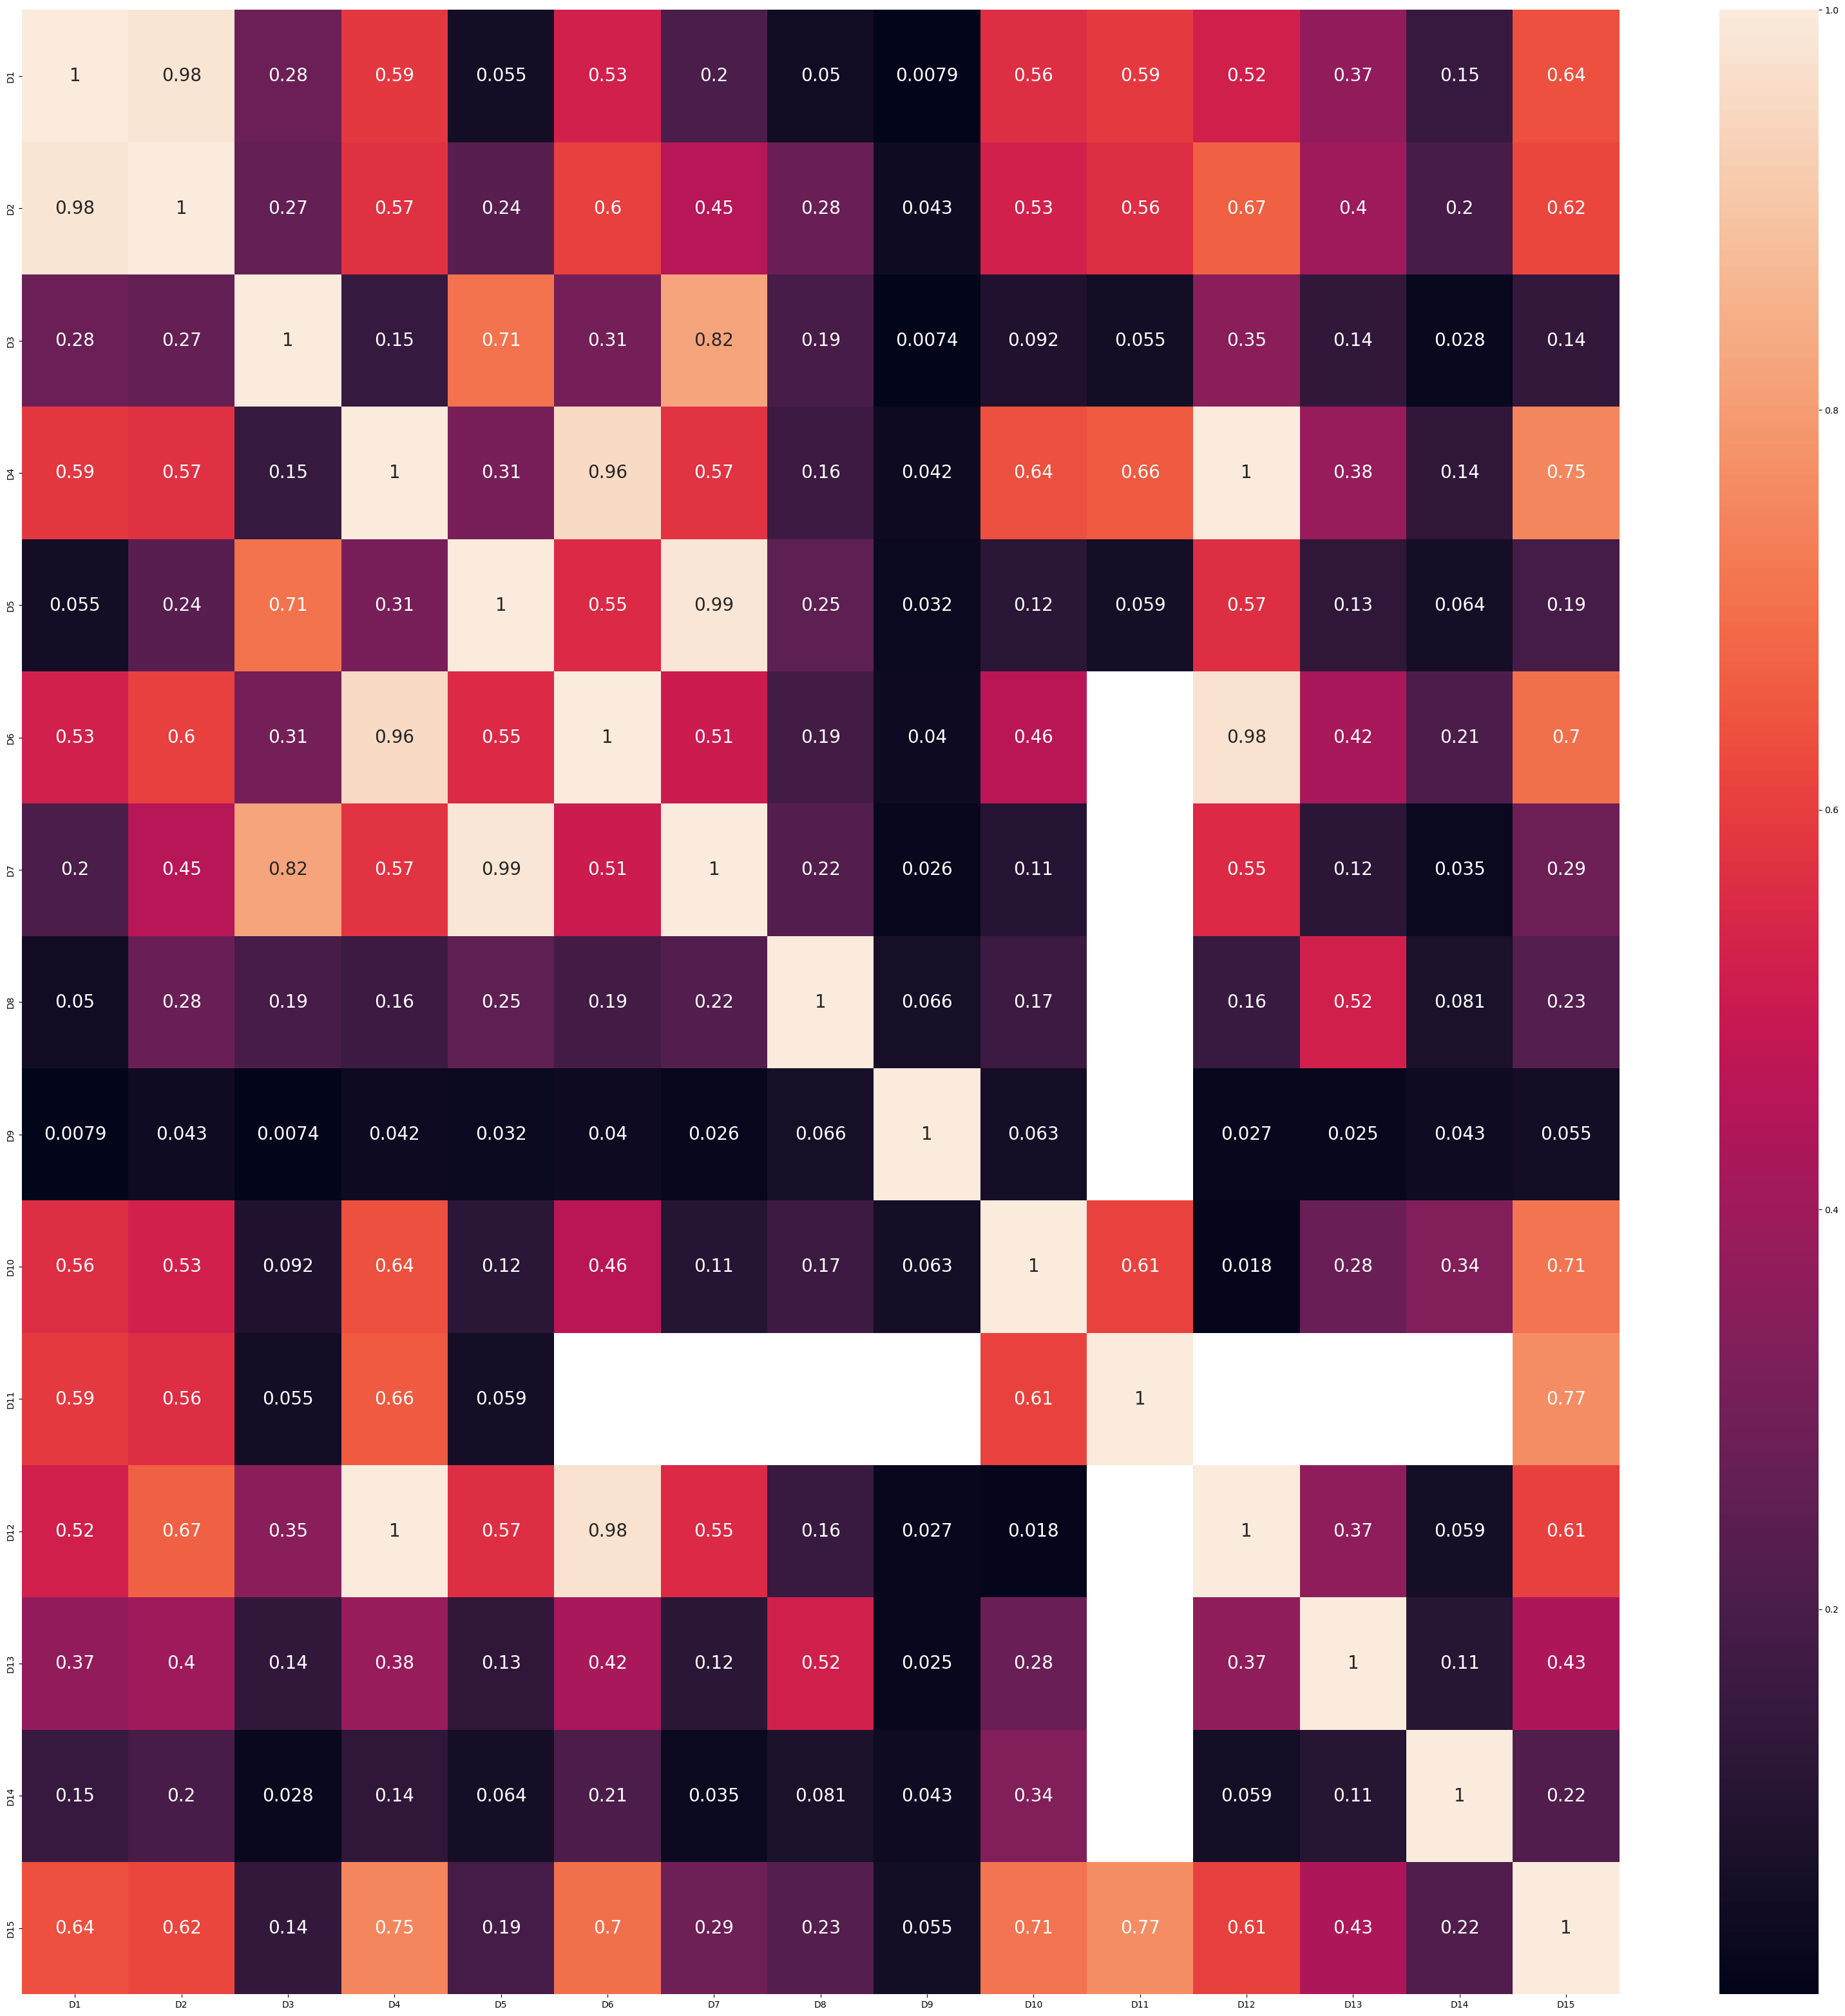

In [10]:
plt.figure(figsize = (40,40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [11]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1).astype(np.bool))

In [12]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [13]:
to_drop

['D2', 'D6', 'D7', 'D12']

In [14]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

C features

In [15]:
C_features_train_df = train_df[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]

In [16]:
cor = C_features_train_df.corr()
cor

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.985202,-0.004896,0.915547,0.335451,0.985657,0.692517,0.872788,0.357944,0.844043,0.996479,0.694775,0.699730,0.950994
C2,0.985202,1.000000,-0.004480,0.925111,0.247305,0.953525,0.767979,0.919789,0.262962,0.899074,0.983838,0.772550,0.635228,0.895904
C3,-0.004896,-0.004480,1.000000,-0.001366,-0.008109,-0.006010,-0.001613,-0.000440,-0.010084,-0.001024,-0.004696,-0.001721,-0.008568,-0.006093
C4,0.915547,0.925111,-0.001366,1.000000,-0.012756,0.905224,0.668491,0.901180,-0.015862,0.864375,0.927645,0.667152,0.400146,0.803997
C5,0.335451,0.247305,-0.008109,-0.012756,1.000000,0.371011,-0.009296,-0.012611,0.925781,-0.012262,0.308095,-0.009258,0.867990,0.544813
C6,0.985657,0.953525,-0.006010,0.905224,0.371011,1.000000,0.598375,0.811429,0.401492,0.777344,0.987563,0.597272,0.716727,0.973415
C7,0.692517,0.767979,-0.001613,0.668491,-0.009296,0.598375,1.000000,0.921312,-0.011560,0.945939,0.702202,0.998147,0.362784,0.506837
C8,0.872788,0.919789,-0.000440,0.901180,-0.012611,0.811429,0.921312,1.000000,-0.015683,0.992506,0.884242,0.921137,0.415432,0.706329
C9,0.357944,0.262962,-0.010084,-0.015862,0.925781,0.401492,-0.011560,-0.015683,1.000000,-0.015248,0.334428,-0.011355,0.852870,0.572618
C10,0.844043,0.899074,-0.001024,0.864375,-0.012262,0.777344,0.945939,0.992506,-0.015248,1.000000,0.856273,0.944043,0.413634,0.674779


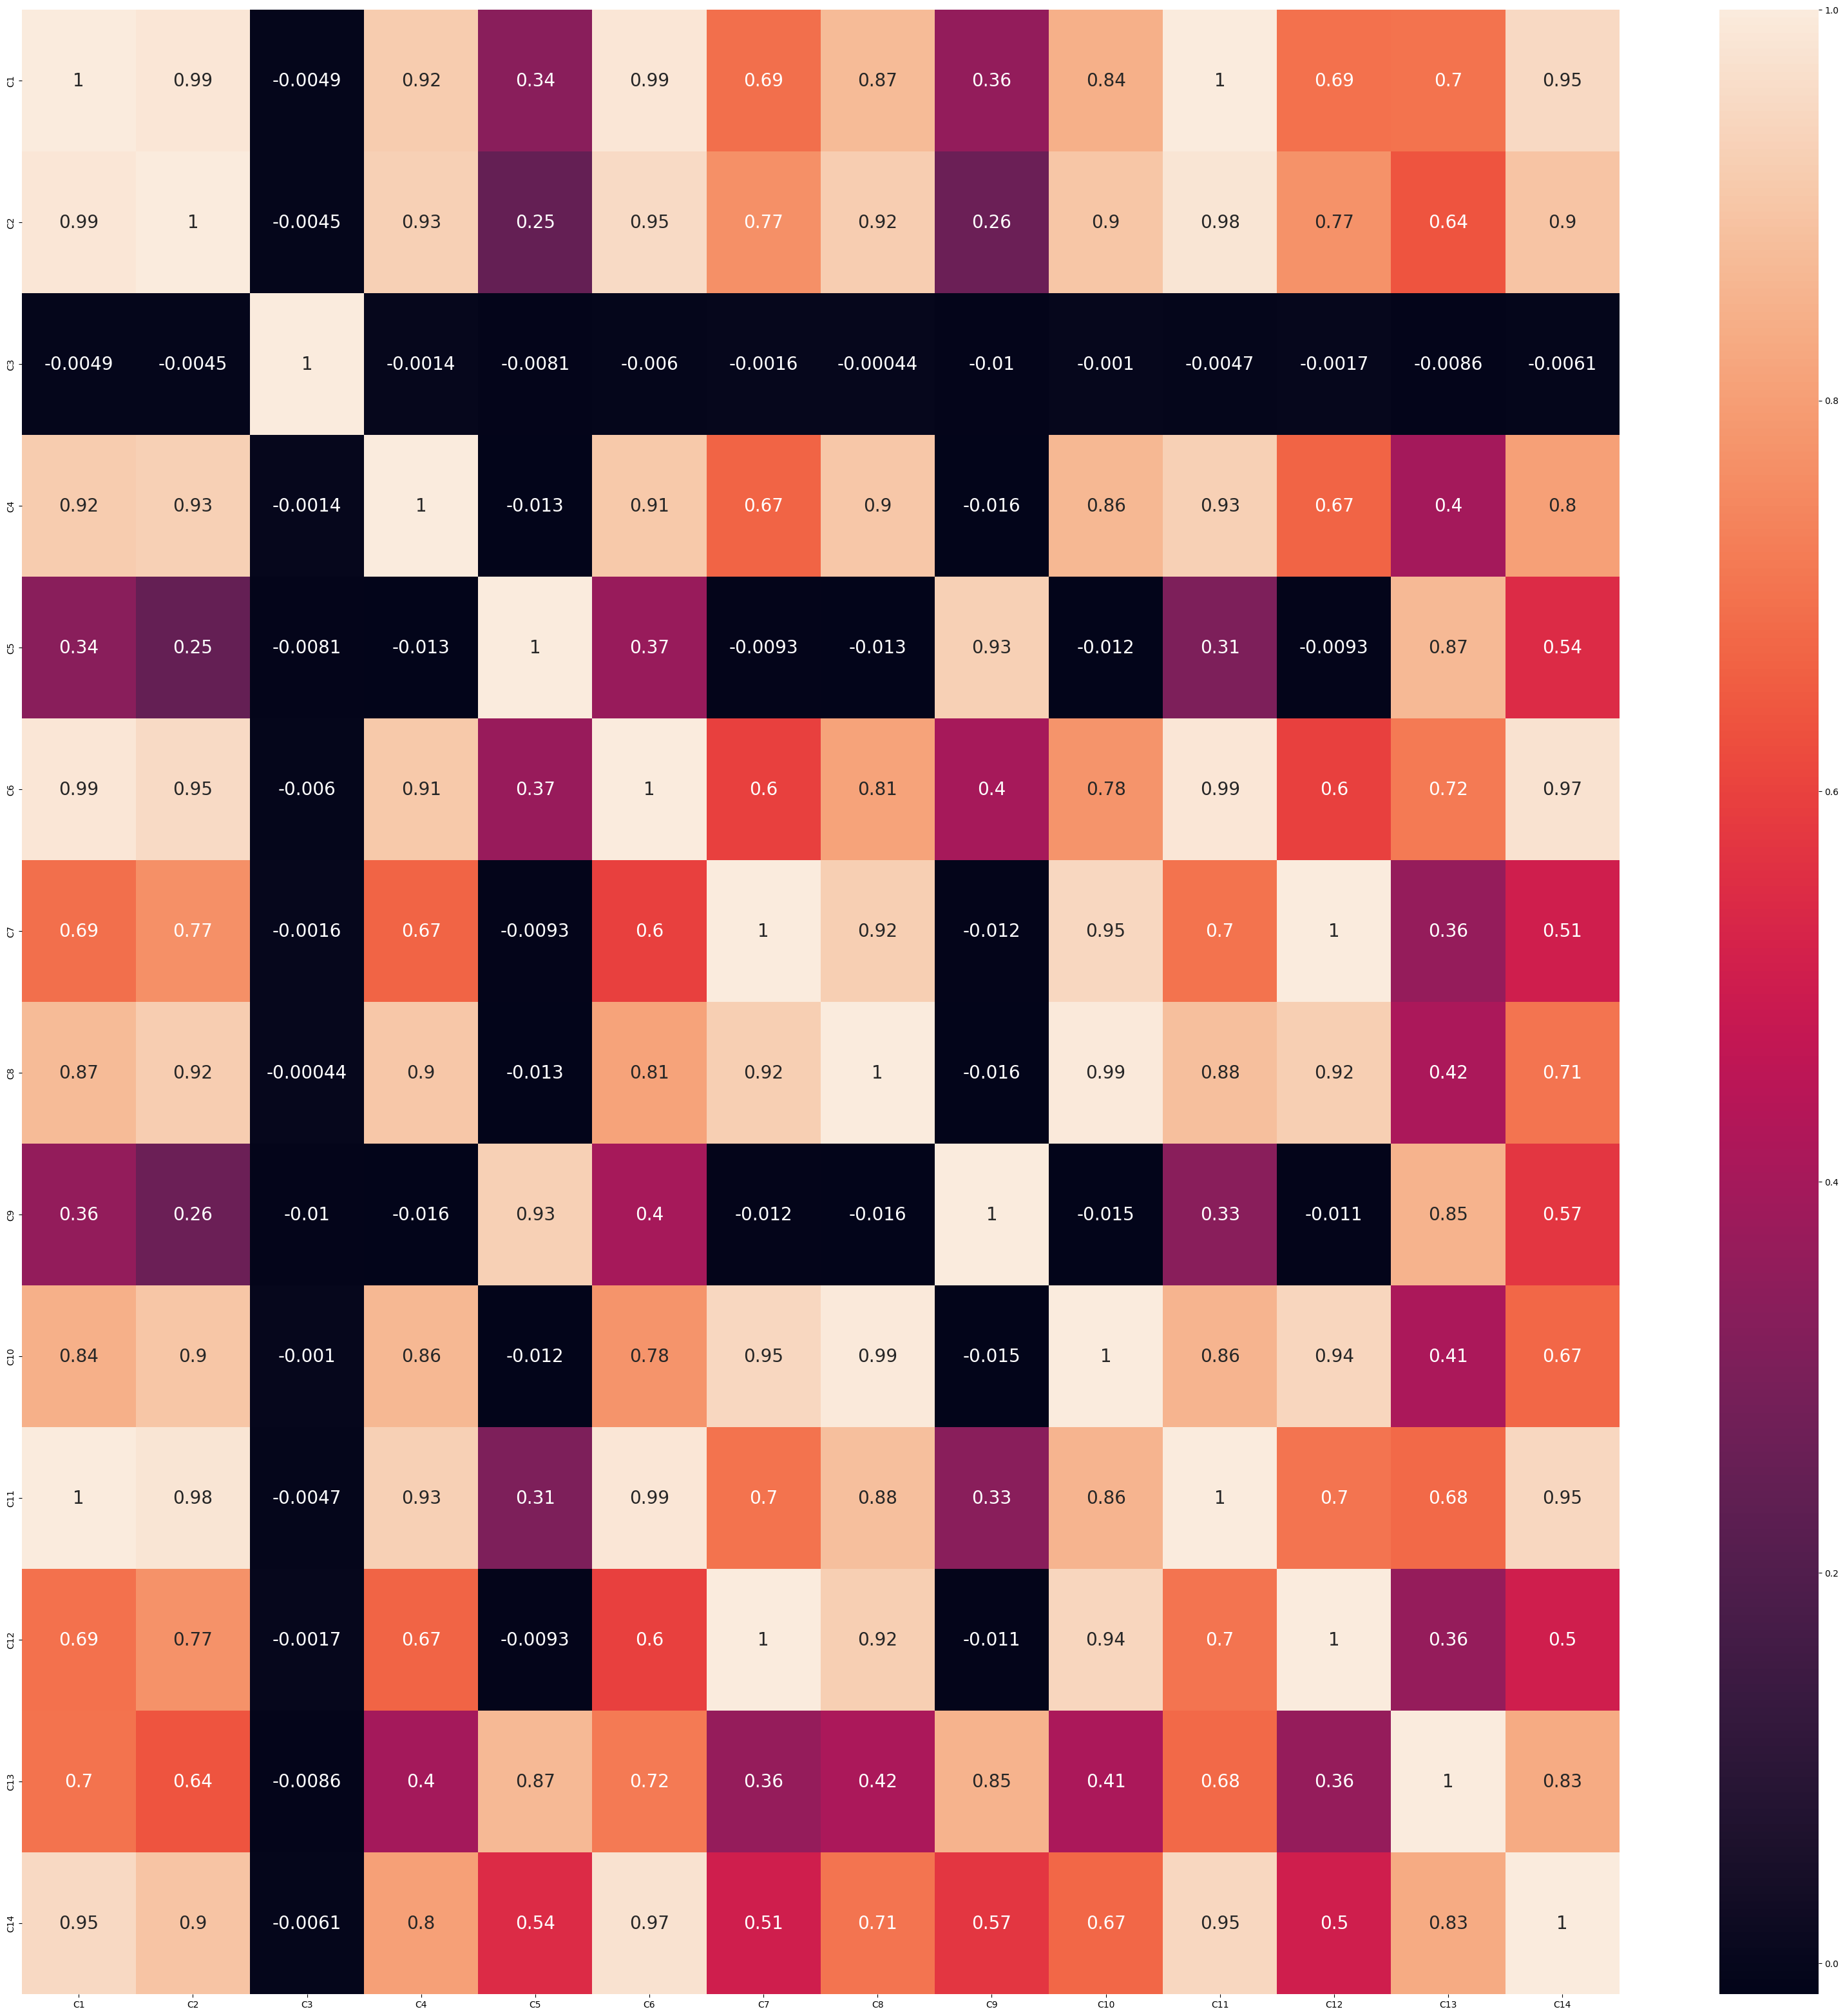

In [17]:
plt.figure(figsize = (40, 40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [18]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1 ).astype(np.bool))

In [19]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [20]:
to_drop

['C2', 'C6', 'C10', 'C11', 'C12', 'C14']

In [21]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [22]:
del D_features_train_df, C_features_train_df

In [23]:
train_df.columns.to_list()

['isFraud',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C3',
 'C4',
 'C5',
 'C7',
 'C8',
 'C9',
 'C13',
 'D1',
 'D3',
 'D4',
 'D5',
 'D8',
 'D9',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V12',
 'V13',
 'V17',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V29',
 'V30',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V40',
 'V43',
 'V44',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V58',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V67',
 'V69',
 'V70',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V92',
 'V94',
 'V95',
 'V96',
 'V99',
 'V100',
 'V102',
 'V103',
 'V105',
 'V108',
 'V109',
 'V112',
 'V115',
 'V123',
 'V124',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V13

# Removing infinity values

In [24]:
# any infitinte value in dataset
train_df.isin([np.inf, -np.inf]).sum().any()

True

In [25]:
# There are few infinity values
df = train_df.isin([np.inf, -np.inf]).sum()[-2:]
print(df)

TransactionAmt_to_std_card1    1444
TransactionAmt_to_std_card4       0
dtype: int64


In [26]:
del df

# Data Imputation

In [27]:
# lets convert this inf value to NaN then impute using the mean

train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
test_df.replace([np.inf, -np.inf], np.nan, inplace = True)


In [28]:
# impute numerical value by median for each feature

for i in train_df.columns:
    if train_df[i].dtypes == 'int64' or train_df[i].dtypes == 'int32' or train_df[i].dtypes == 'int16' or train_df[i].dtypes == 'int8' or train_df[i].dtypes == 'float64' or train_df[i].dtypes == 'float32' or train_df[i].dtypes == 'float16' :
        train_df[i].fillna(train_df[i].median(), inplace = True )
        

In [29]:
# imputation of categorical features by mode 

for i in train_df.columns:
    if train_df[i].dtypes == 'object':
        train_df[i].fillna(train_df[i].mode()[0], inplace = True)


In [30]:
train_df.isnull().sum().any()

False

In [31]:
# imputation of numerical features with median

for i in test_df.columns:

    if test_df[i].dtypes == 'int64' or test_df[i].dtypes == 'int32' or test_df[i].dtypes == 'int16' or test_df[i].dtypes == 'int8' or test_df[i].dtypes == 'float64' or test_df[i].dtypes == 'float32' or test_df[i].dtypes == 'float16' :
        test_df[i].fillna(test_df[i].median(), inplace = True)
        

In [32]:
# imputation of categorical features by mode

for i in test_df.columns:
    if test_df[i].dtypes == 'object':
        test_df[i].fillna(test_df[i].mode()[0], inplace = True)
        

In [33]:
test_df.isnull().sum().any()

False

In [34]:
# encoding categorical feature before model training using label encoder
from sklearn.preprocessing import LabelEncoder

for i in train_df.columns:
  if train_df[i].dtypes == "object":
    le = LabelEncoder()
    train_df[i] = le.fit_transform(train_df[i].astype(str).values)


In [35]:
#encoding test data using laber encoder

for i in test_df.columns:
  if test_df[i].dtypes == "object":
    le = LabelEncoder()
    test_df[i] = le.fit_transform(test_df[i].astype(str).values)
    

In [36]:
train_df.describe()

,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C1,C3,C4,C5,C7,C8,C9,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V5,V6,V12,V13,V17,V19,V20,V23,V24,V25,V26,V29,V30,V33,V34,V35,V36,V37,V38,V40,V43,V44,V45,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V58,V60,V61,V62,V63,V64,V67,V69,V70,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V90,V91,V92,V94,V95,V96,V99,V100,V102,V103,V105,V108,V109,V112,V115,V123,V124,V126,V127,V128,V129,V130,V131,V132,V133,V134,V136,V137,V138,V139,V140,V142,V143,V145,V146,V147,V149,V150,V151,V152,V156,V157,V158,V159,V160,V161,V162,V164,V165,V166,V169,V170,V171,V174,V178,V180,V182,V184,V187,V188,V189,V198,V200,V201,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V217,V218,V219,V220,V221,V222,V224,V226,V227,V229,V232,V233,V234,V238,V245,V251,V253,V254,V256,V257,V258,V259,V261,V262,V264,V265,V266,V267,V268,V269,V270,V271,V272,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V288,V289,V291,V292,V293,V294,V295,V296,V298,V300,V301,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V320,V321,V323,V326,V329,V331,V332,V333,V334,V335,V336,V338,V339,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,day,hour,hour_alertFeature,LogTransactionAmt,new_card3,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,device_name,device_version,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4
count,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.000000,589949.0,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.00000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.000000,589949.000000,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.0,589949.000000,589949.000000,589949.000000,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.0,589949.000000,589949.000000,589949.000000,589949.0,589949.0000,589949.0,5

Train Test split

In [37]:
train_df = train_df.sample(frac = .7)

In [38]:
#Train test split

train_data = train_df[:int(train_df.shape[0]*0.70)]
cv_data = train_df[int(train_df.shape[0]*0.70):]

In [39]:
#X-y split

x_train = train_data.drop(['isFraud'], axis = 1)
y_train = train_data['isFraud']
x_cv = cv_data.drop(['isFraud'], axis = 1)
y_cv = cv_data['isFraud']


Feature Scaling

In [40]:
#standardizing the train and cv x for logistic regression model

sc = StandardScaler()
sc_x_train = sc.fit_transform(x_train)
sc_x_cv = sc.transform(x_cv)


# 3.1 ML Models

# Logistic Regression

In [42]:
#traing model with default values

clf = SGDClassifier(loss = "log")
clf.fit(sc_x_train, y_train)
y_trainpred = clf.predict_proba(sc_x_train)
y_cvpred = clf.predict_proba(sc_x_cv)


In [43]:
print('Train AUC is :', roc_auc_score(y_train, y_trainpred[:,1]))
print('CV AUC :', roc_auc_score(y_cv, y_cvpred[:,1]))

Train AUC is : 0.8477240010845394
CV AUC : 0.8430560588579149


Now, doing hyperparamter tuning to improve the results.

In [44]:
parameters = {"alpha":[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
clf = SGDClassifier(loss = "log", class_weight = 'balanced', penalty = "l2")
rand_clf = RandomizedSearchCV(clf, parameters, scoring = "f1", n_iter = 500, n_jobs = -1, cv = 5, random_state = 1, return_train_score = True)
rand_clf.fit(sc_x_train, y_train)
print(rand_clf.best_params_)
print("="*75)
print(rand_clf.best_estimator_)
print("="*75)

{'alpha': 0.001}
SGDClassifier(alpha=0.001, class_weight='balanced', loss='log')


We got best cv accuracy with alpha value as 0.01

In [45]:
#training with best parameters now

clf_lr = SGDClassifier(loss = "log", class_weight = "balanced", alpha = rand_clf.best_params_["alpha"], penalty = "l2")
clf_lr.fit(sc_x_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log')

AUC score

In [46]:
y_trainpred = clf_lr.predict(sc_x_train)
pred_prob_train = clf_lr.predict_proba(sc_x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

Train AUC = 0.8601005594187614


In [47]:
y_cvpred = clf_lr.predict(sc_x_cv)
pred_prob_cv = clf_lr.predict_proba(sc_x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

CV AUC = 0.857263351242873


F1 Score

In [48]:
f1_score(y_train, y_trainpred)

0.21332833172223747

Confusion Matrix

In [49]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

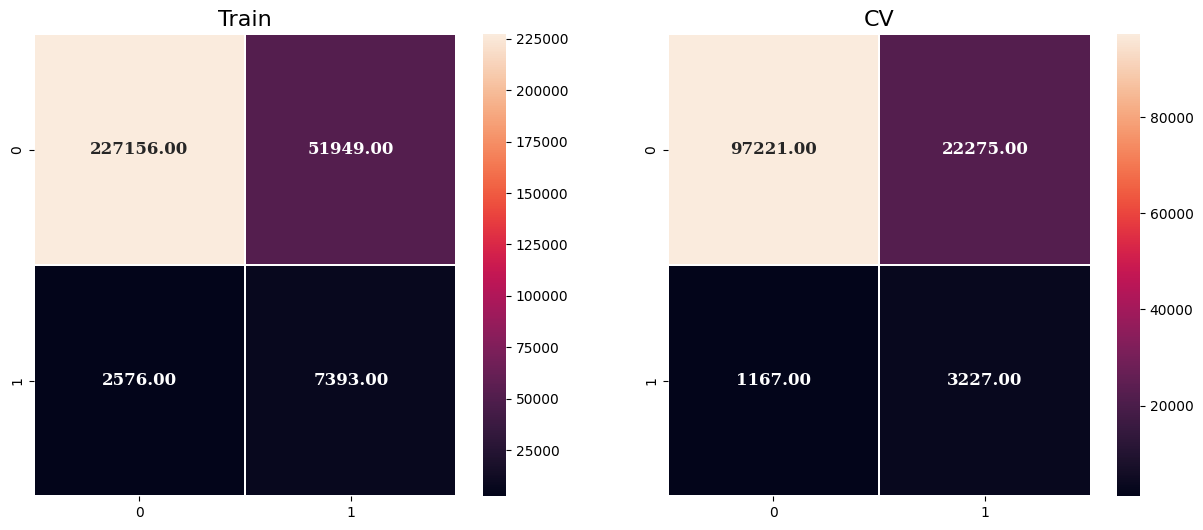

In [50]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

ROC AUC curve

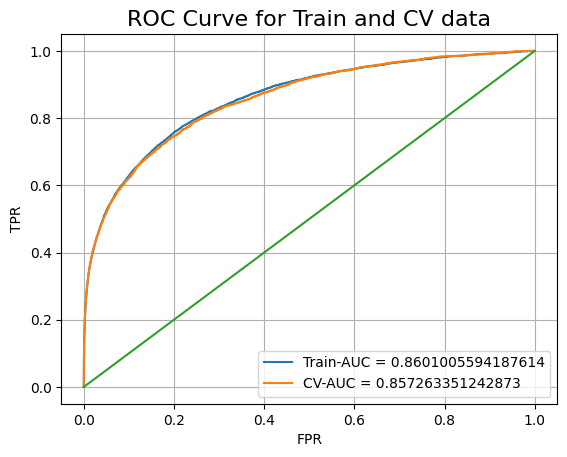

In [51]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0, 1.0], [0.0, 1.0])

plt.title("ROC Curve for Train and CV data", fontsize = 16)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# Desicison Tree

In [52]:
# default paramter

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_train_pred = clf.predict_proba(x_train)
y_cv_pred = clf.predict_proba(x_cv)

In [53]:
print('Train AUC with default parameter:', roc_auc_score(y_train, y_train_pred[:,1]))
print('CV AUC with default parameter:', roc_auc_score(y_cv, y_cv_pred[:,1]))

Train AUC with default parameter: 1.0
CV AUC with default parameter: 0.7594981268467603


Hyperparmeter tuning

In [54]:
parameter = {          
             "max_depth":[3, 5, 7, 9, 11, 13, 15],
             "criterion": ["gini", "entropy","log_loss"],
                       
            }

In [55]:
clf = DecisionTreeClassifier(class_weight = 'balanced')
rand_clf = RandomizedSearchCV(clf, parameter, scoring = 'f1', n_jobs = -1)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'max_depth': 15, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight='balanced', max_depth=15)


In [56]:
#traing with best parameters

clf_dt = DecisionTreeClassifier( max_depth = 15, criterion = 'gini', class_weight = 'balanced')
clf_dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15)

AUC score

In [57]:
y_trainpred = clf_dt.predict(x_train)
pred_prob_train = clf_dt.predict_proba(x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

Train AUC = 0.9459275156579025


In [58]:
y_cvpred = clf_dt.predict(x_cv)
pred_prob_cv = clf_dt.predict_proba(x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

CV AUC = 0.8316126353808435


F1 score

In [59]:
f1_score(y_train, y_trainpred)

0.3530668419539049

Confusion matrix

In [60]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

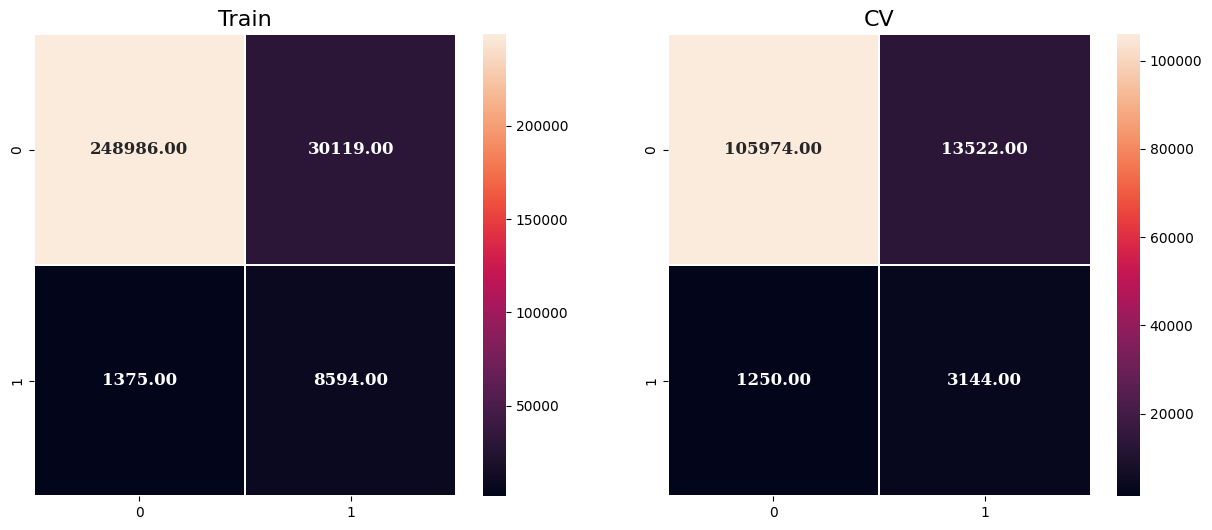

In [61]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

ROC AUC curve

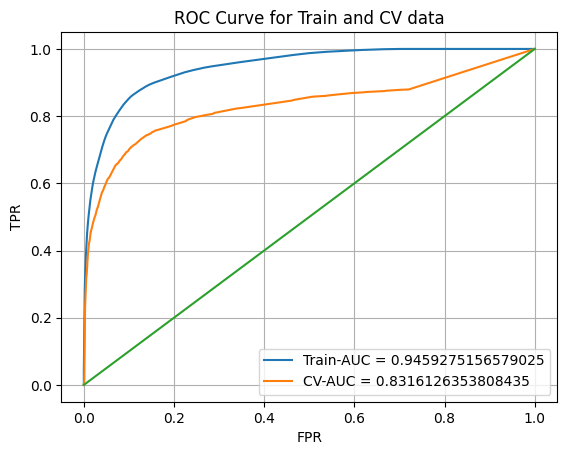

In [62]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])

plt.title("ROC Curve for Train and CV data")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# Random Forest

In [63]:
#first try with the default paramter
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_trainpred = clf.predict_proba(x_train)
y_cvpred = clf.predict_proba(x_cv)

In [64]:
print('train auc with default parameter:', roc_auc_score(y_train,y_trainpred[:,1]))
print('cv auc with default parameter:', roc_auc_score(y_cv,y_cvpred[:,1]))

train auc with default parameter: 0.9999999999999999
cv auc with default parameter: 0.9177536597801192


Hyperparameter tuning

In [65]:
random_parameter = {
 'bootstrap': [True, False],
 'max_depth': [3, 5, 7, 9, 11, 13, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [25, 50, 100, 200, 300, 500, 700, 900, 1000]
}


In [66]:
clf = RandomForestClassifier()
rand_clf = RandomizedSearchCV(clf, random_parameter, n_iter = 10, scoring = 'f1', cv = 3, n_jobs = -1, return_train_score = True)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*75)
print(rand_clf.best_estimator_)

KeyboardInterrupt: ignored

In [67]:
#training with best parameter
clf_rf = RandomForestClassifier(n_estimators = 25, max_features = 'auto', max_depth = None, bootstrap = True)
clf_rf.fit(x_train, y_train)

RandomForestClassifier(max_features='auto', n_estimators=25)

AUC score

In [68]:
y_trainpred = clf_rf.predict(x_train)
pred_prob_train = clf_rf.predict_proba(x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

Train AUC = 0.9999992790390937


In [69]:
y_cvpred = clf_rf.predict(x_cv)
pred_prob_cv = clf_rf.predict_proba(x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

CV AUC = 0.8937391695401371


F1 score

In [70]:
f1_score(y_train, y_trainpred)

0.988689962976112

Confusion matrix

In [71]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

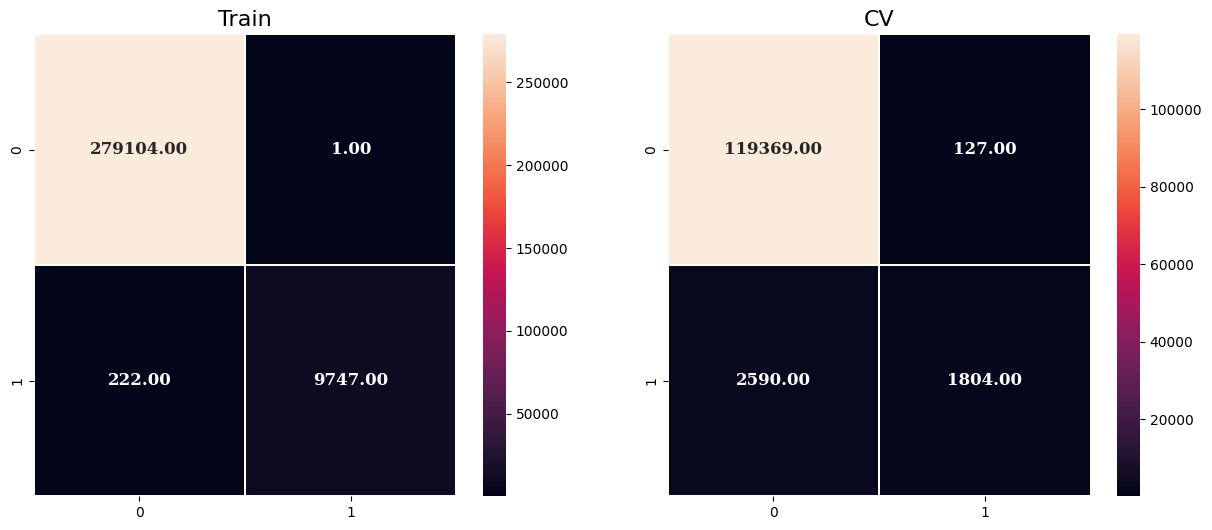

In [72]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

ROC AUC score

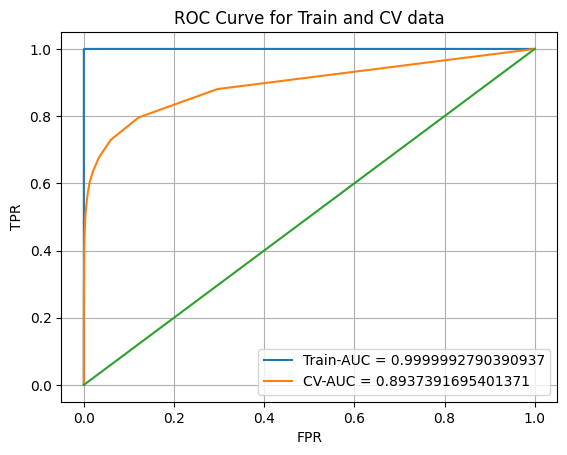

In [73]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])

plt.title("ROC Curve for Train and CV data")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# LGBM

In [ ]:

parameter_lgbm = {
             'max_depth':[1, 3, 4, 5],
             'learning_rate':[0.001, 0.01, 0.1], 
             'n_estimators': [100, 300, 500, 600, 800, 1100],
             'min_child_samples': sp_randint(100, 400), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1],
             'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 12]
             }


In [ ]:
# training model with hypertuned lgbm
clf = LGBMClassifier(class_weight = 'balanced')
rand_clf = RandomizedSearchCV(clf, parameter_lgbm, scoring = "f1", return_train_score = True)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

In [74]:
#training with best parameter
clf_lgbm = LGBMClassifier(class_weight = "balanced", max_depth = 5, min_child_samples = 377, min_child_weight = 10.0, n_estimators = 1100, reg_alpha = 7, reg_lambda = 0, subsample = 0.5489, learning_rate = 0.1)
clf_lgbm.fit(x_train, y_train)


LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=377,
               min_child_weight=10.0, n_estimators=1100, reg_alpha=7,
               reg_lambda=0, subsample=0.5489)

AUC score

In [75]:
y_trainpred = clf_lgbm.predict(x_train)
pred_prob_train = clf_lgbm.predict_proba(x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

Train AUC = 0.9893007025852084


In [76]:
y_cvpred = clf_lgbm.predict(x_cv)
pred_prob_cv = clf_lgbm.predict_proba(x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

CV AUC = 0.9503364156006585


F1 score

In [77]:
f1_score(y_train, y_trainpred)

0.5832945339417078

Confusion matrix

In [78]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

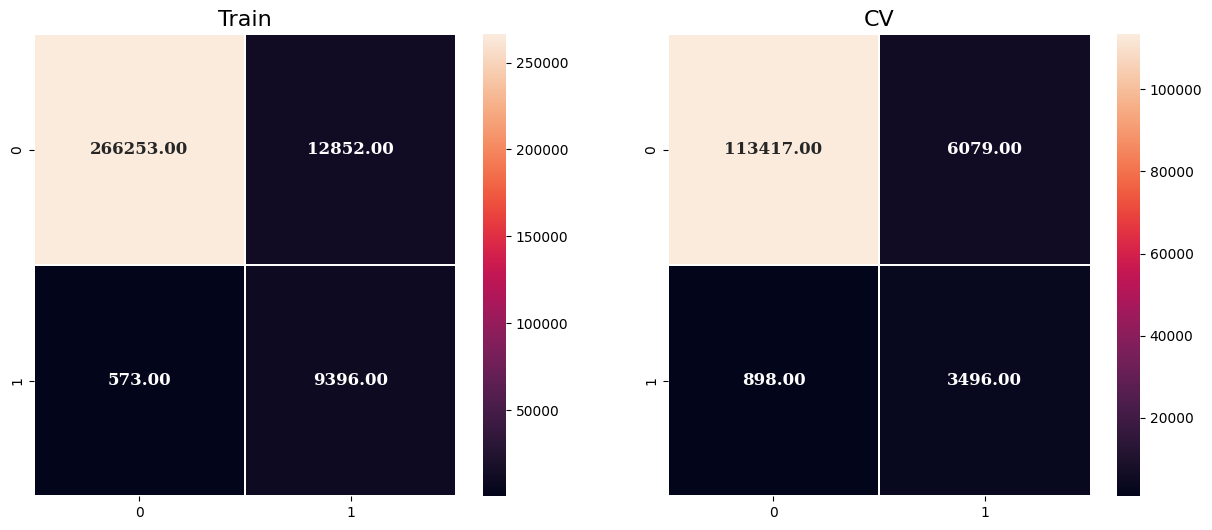

In [79]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

ROC AUC curve

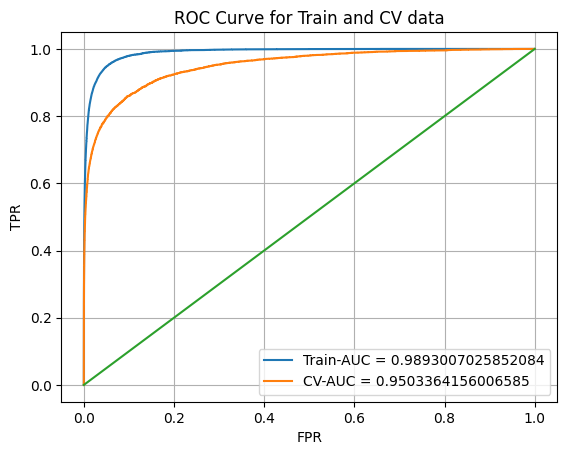

In [80]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])

plt.title("ROC Curve for Train and CV data")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# Conclusion

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Model","Reg","Alpha","n_estimators","Depth","Train-AUC","CV-AUC"]
table.add_row(['Logistic Regression','L2','0.01','_','_','85.86','85.79'])
table.add_row(['Decison Tree','_','_','_','15','94.65','83.30'])
table.add_row(['Random Forest','_','_','25','None','94.65','83.30'])
table.add_row(['LGBM','_',7,1100,5,'98.91','94.77'])
print(table)

LGBM gives the best CV auc results.